Use model trained in classify_spikes.py to recommend electrodes to sort <br>
Recommendations should err on side of more false positives (high recall) if needed
so as not to miss electrodes

In [28]:
import os
from time import time
import re
import sys
import json

import tables
import numpy as np
import pylab as plt
import pandas as pd
from joblib import dump, load
import xgboost as xgb
from tqdm import tqdm
from sklearn.metrics import recall_score, confusion_matrix

In [4]:
# Load paths
with open('path_vars.json','r') as path_file:
    path_vars = json.load(path_file)

h5_path = path_vars['h5_path'] # Path to HDF5 file where waveform data is stored
model_save_dir = path_vars['model_save_dir'] # Directory in which trained model will be saved
ephys_module_path = path_vars['ephys_module_path'] # Directory with ephys module code
waveform_file_path = path_vars['waveform_file_path'] # Directory containing file with wanted waveform file paths

sys.path.append(ephys_module_path)
from ephys_data import ephys_data

In [ ]:
# Load classifier pipeline
clf = load(os.path.join(model_save_dir, 'xgb_pipeline'))

In [33]:
# # Get details for files containing waveforms
# waveform_file_list = [x.strip()
#                       for x in open(waveform_file_path, 'r').readlines()]
# waveform_basename_list = [x.split('/')[-4] for x in waveform_file_list]
# waveform_elec_list = [re.findall('\d+', x.split('/')[-2])[0]
#                       for x in waveform_file_list]
# waveform_data_dir = ["/".join(x.split('/')[:-3]) for x in waveform_file_list]

In [9]:
# # Compile details into pandas frame
# path_frame = pd.DataFrame({
#     'path': waveform_file_list,
#     'basename': waveform_basename_list,
#     'data_dir': waveform_data_dir,
#     'electrode': waveform_elec_list})
# path_frame.electrode = path_frame.electrode.astype('int32')
# unique_frame = path_frame.drop_duplicates('data_dir')

In [22]:
# # Find out whether each electrode contains a sorted neuron or not
# pos_frames = []
# for this_dir in unique_frame.data_dir:
#     dat = ephys_data(this_dir)
#     dat.get_region_units()
#     pos_electrodes = np.unique([x[1] for x in dat.unit_descriptors])
#     this_frame = pd.DataFrame({
#         'data_dir': this_dir,
#         'electrode': pos_electrodes,
#         'unit': True})
#     pos_frames.append(this_frame)

# fin_pos_frame = pd.concat(pos_frames)

# path_frame = path_frame.merge(fin_pos_frame, how='outer')
# path_frame.fillna(False, inplace=True)
# path_frame['electrode_str'] = [f'{x:02}' for x in path_frame.electrode]

# path_frame['array_name'] = path_frame.basename + '_elec' +\
#     path_frame.electrode_str

In [ ]:
# # For each electrode, calculate class probabilities and save in dataframe
# path_frame['proba'] = None
# for num, path in tqdm(enumerate(path_frame.path)):
#    x = np.load(path)
#    if x.shape[1] == 75:
#        proba = clf.predict_proba(x)
#    elif x.shape[1] == 750:
#        x_temp = x[:,::10]
#        proba = clf.predict_proba(x_temp)
#    else:
#        proba = np.nan
#    path_frame['proba'].loc[num] = proba

# Save frame to avoid having to calculate proba again
# path_frame.to_pickle(os.path.join(model_save_dir,'path_frame.pkl'))

In [23]:
# Load path_frame instead of recalculating everything
path_frame = pd.read_pickle(os.path.join(model_save_dir, 'path_frame.pkl'))

(0.0, 1.0)

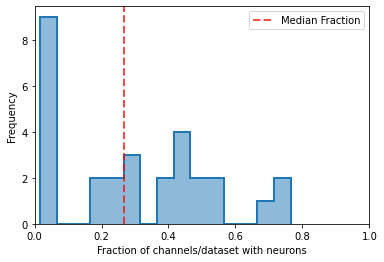

In [25]:
# Calculate and plot fraction of channels/dataset containing sorted neurons
mean_unit_frac = path_frame.groupby('basename').agg({'unit': 'mean'})['unit']

cmap = plt.get_cmap('tab10')
plt.hist(mean_unit_frac, alpha=0.5, bins=15, color=cmap(0))
plt.hist(mean_unit_frac, histtype='step', bins=15, color=cmap(0),
         linewidth=2)
plt.axvline(np.median(mean_unit_frac), color='red', alpha=0.7,
            linewidth=2, label='Median Fraction', linestyle='--')
plt.legend()
plt.xlabel('Fraction of channels/dataset with neurons')
plt.ylabel('Frequency')
plt.xlim([0, 1])

In [32]:
# We want atleast 2000 waveforms to want to look at an electrodes
unit_vec = path_frame.unit.to_numpy() # True label : whether a channel had a sorted neuron
proba_vec = path_frame.proba.to_numpy() # Predicted label : for each waveform for each channel

fin_proba_vec = [x[:, 1] for x in proba_vec] # Only interested in probability of class 1 = Spike
pred_spike_count = [np.sum(x > 0.18) for x in fin_proba_vec] # Apply threshold from "classify_spikes"
rec_channel_vec = np.array(pred_spike_count) > 2000 # We want at least 2000 predicted true per channel, otherwise ignore channel

############################33
# Calculate classification stats

recall = recall_score(unit_vec, rec_channel_vec)
# Given no neuron, how many channels did we correctly throw out
true_negative = confusion_matrix(unit_vec, rec_channel_vec, normalize='all')[0,0]

print(f'Recall given current threshold : {recall}')
print(f'True negatives given current threshold : {true_negative}')

Recall given current threshold : 0.9896265560165975
True negatives given current threshold : 0.41467676179382645
